In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.colors as mcolors

from scipy.interpolate import BSpline, CubicSpline

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.float_format', lambda x: '%.3f' % x)


short_bucket = [0, 31, 92, 182, 273]
commercial_bank = [
    '국민은행', '신한은행', '우리은행', '하나은행', '외환은행']


In [9]:
def info_merge(merge: pd.DataFrame) -> None:
    print(merge.shape)
    print(merge.columns)
    print(merge["_merge"].value_counts())
    print(merge["_merge"].value_counts() / merge.shape[0]* 100)

#### Risk Free

In [127]:
seibro_repo = pd.read_csv('seibro/seibro_repo_gov.csv')
seibro_repo.rename(columns={'CALENDAR_DT':'date'}, inplace=True)
seibro_repo['date'] = pd.to_datetime(seibro_repo['date'].astype(str), format='%Y%m%d')
seibro_repo.set_index('date', drop=True, inplace=True)

In [128]:
ecos = pd.read_csv("시장금리(일별)_22134723.csv").replace("-", None)
ecos = ecos.melt(id_vars=["계정항목"], var_name="date", value_name="yield")
ecos["date"] = pd.to_datetime(ecos["date"], errors="coerce")
ecos = ecos.dropna(subset=["date"])
ecos = ecos.pivot_table(index="date", columns="계정항목", values="yield").astype(float)
ecos = ecos.reset_index()
ecos.set_index('date', drop=True, inplace=True)

C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2443353533.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ecos["date"] = pd.to_datetime(ecos["date"], errors="coerce")


In [129]:
ref = pd.merge(ecos, seibro_repo, how='left', left_index=True, right_index=True)

t = range(0, 366*10+1)

def interpolate_cubicspline(g):
    g = g.dropna()
    X = g['Maturity']*365  # Convert days to years for the x-axis
    Y = g['Yield']*100

    if(len(X)<2) : return None

    spline = CubicSpline(X, Y)

    return pd.Series(spline(t))

##### 1. Call Rate

In [137]:
ref_gb = ref.loc[:, ['  콜금리(1일, 전체거래)', '국고채(1년)', '국고채(2년)', '국고채(3년)', '국고채(5년)', '국고채(10년)', '국고채(20년)', '국고채(30년)', '국고채(50년)']]
ref_gb.columns = [str(1/365)] + (ref_gb.columns[1:]).str.extract(r'(\d+)').squeeze().to_list()
ref_gb = ref_gb.astype(float)

rfr = ref_gb.reset_index().melt(id_vars=['date'], var_name='Maturity', value_name='Yield')
rfr['Maturity'] = rfr['Maturity'].astype(float)
rfr = rfr.groupby('date').apply(interpolate_cubicspline)
rfr = rfr.dropna().reset_index()

rfr['date'] = pd.to_datetime(rfr['date'], errors='coerce')
rfr = rfr.melt(id_vars=['date'], var_name='TimeToMaturity', value_name='RFR')
rfr['TimeToMaturity'] = rfr['TimeToMaturity'].astype(int)
rfr.set_index(['date', 'TimeToMaturity'], inplace=True)

C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\814345349.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rfr = rfr.groupby('date').apply(interpolate_cubicspline)


In [138]:
rfr

,,RFR
date,TimeToMaturity,
2001-01-02,0,527.380
2001-01-03,0,527.405
2001-01-04,0,529.523
2001-01-05,0,533.636
2001-01-08,0,531.660
...,...,...
2024-12-16,3660,272.044
2024-12-17,3660,278.940
2024-12-18,3660,273.759


##### 2. REPO

In [140]:
ecos_gb = ref.loc[:, ['DAYONE', '국고채(1년)', '국고채(2년)', '국고채(3년)', '국고채(5년)', '국고채(10년)', '국고채(20년)', '국고채(30년)', '국고채(50년)']]
ecos_gb.columns = [str(1/365)] + (ecos_gb.columns[1:]).str.extract(r'(\d+)').squeeze().to_list()
ecos_gb = ecos_gb.astype(float)

rfr_repo = ecos_gb.reset_index().melt(id_vars=['date'], var_name='Maturity', value_name='Yield')
rfr_repo['Maturity'] = rfr_repo['Maturity'].astype(float)
rfr_repo = rfr_repo.groupby('date').apply(interpolate_cubicspline)
rfr_repo = rfr_repo.dropna().reset_index()


rfr_repo['date'] = pd.to_datetime(rfr_repo['date'], errors='coerce')
rfr_repo = rfr_repo.melt(id_vars=['date'], var_name='TimeToMaturity', value_name='RFR_REPO')
rfr_repo['TimeToMaturity'] = rfr_repo['TimeToMaturity'].astype(int)
rfr_repo.set_index(['date', 'TimeToMaturity'], inplace=True)


C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2188298206.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rfr_repo = rfr_repo.groupby('date').apply(interpolate_cubicspline)


#### CD

In [190]:
seibro = pd.read_csv("seibro\seibro_cd_issue.csv")
seibro["기준일자"] = pd.to_datetime(seibro["기준일자"], format="%Y%m%d").dt.strftime("%Y-%m-%d")

issue = pd.read_csv("seibro\seibro_cd_issue_detail.csv")
issue.loc[issue["VALAT_GRD_CD_NM"]=="취소", "VALAT_GRD_CD_NM"] = None
issue = issue.sort_values(["발행은행신용등급","VALAT_GRD_CD_NM"]).drop_duplicates(subset=["종목코드"])
issue = pd.merge(
    issue, seibro[["종목번호", "발행인유형"]].drop_duplicates(), 
    left_on="종목코드", right_on="종목번호", how="left")
issue = issue[issue["발행통화"]=="KRW"]

issue["days_to_maturity"] = pd.to_datetime(issue["만기일"]) - pd.to_datetime(issue["발행일"])
issue["days_to_maturity"] = issue["days_to_maturity"].dt.days
issue = issue[issue["days_to_maturity"] <= 250]
issue = issue[issue["발행금액"] > 9000000000]

issue["발행금액"].describe()

count            3507.000
mean     103369772071.164
std       89465102973.012
min       10000000000.000
25%       50000000000.000
50%       80000000000.000
75%      130000000000.000
max     1000000000000.000
Name: 발행금액, dtype: float64

In [223]:

trans = pd.read_csv("seibro/seibro_cd_trans.csv").drop(
    columns=["NUM", "증권구분", "date"])

merge = pd.merge(
    trans, issue, on=["종목번호"], how="left", validate="m:1", indicator=True
).drop(
    columns=["종목명_y", "발행일_y", "만기일_y"]
).rename(
    columns={
    "SETL_AMT": "매매금액",
    "종목명_x": "종목명", "발행일_x": "발행일", "만기일_x": "만기일",
})
merge = merge[merge["통화"]=="KRW"]
merge = merge[merge["발행인유형"]=="시중은행"]
merge = merge.drop(columns=[
    "통화", "발행인유형", "SHORTM_FNCEGD_CD", "SELLER_INDTP_TPCD", "BUYER_INDTP_TPCD", "발행통화", "발행은행코드",
    "잔존만기", "days_to_maturity"
])
merge = merge[merge["종목명"].str.contains(r"(국민|신한|우리|하나|외환)", na=False, regex=True)]

merge = merge[merge["매매금액"] > 0]
merge = merge[merge["발행은행신용등급"]=="AAA0(A1)"]
merge = merge.reset_index(drop=True)

merge["기준일자"] = pd.to_datetime(merge["기준일자"], format="%Y%m%d")
merge["만기일"] = pd.to_datetime(merge["만기일"], format="%Y%m%d")
merge["times_to_maturity"] = merge["만기일"] - merge["기준일자"]
merge["times_to_maturity"] = merge["times_to_maturity"].dt.days

merge["금리"] = merge["금리"].astype(float)
merge["기준일자"] = pd.to_datetime(merge["기준일자"], format="%Y%m%d")

print(merge["기준일자"].min(), merge["기준일자"].max())


info_merge(merge)

2012-05-24 00:00:00 2024-11-14 00:00:00
(29926, 29)
Index(['기준일자', '매도유형', '매수유형', '매매금액', '금리', '종목번호', '종목명', '발행일', '만기일',
       'GOODS_LEF_XPIR_TPCD', '발행은행', 'ISSUCO_CUSTNO', 'REP_SECN_NM', '종목코드',
       '액면금액', '매출금액', '발행금액', '할인율', '잔존일물', '발행형태', '지급은행지점코드',
       'PAY_BANK_MOFNO', '발행은행신용등급', '지급은행', 'CREDITRT_DT', 'VALAT_GRD_CD_NM',
       '등록일자', '_merge', 'times_to_maturity'],
      dtype='object')
_merge
both          29926
left_only         0
right_only        0
Name: count, dtype: int64
_merge
both         100.000
left_only      0.000
right_only     0.000
Name: count, dtype: float64


C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2405391163.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merge = merge[merge["종목명"].str.contains(r"(국민|신한|우리|하나|외환)", na=False, regex=True)]


#### Curve

In [224]:
cd = merge

In [225]:
cd["기준월"] = cd["기준일자"].dt.to_period("M")

cd_call = pd.merge(cd, rfr, left_on=['기준일자', 'times_to_maturity'], right_index=True, how='left')
cd_call["spread"] = cd_call["금리"]*100 - cd_call["RFR"]

cd_repo = pd.merge(cd, rfr_repo, left_on=['기준일자', 'times_to_maturity'], right_index=True, how='left')
cd_repo["spread"] = cd_repo["금리"]*100 - cd_repo["RFR_REPO"]

cd_call["spread"].describe(), cd_repo["spread"].describe()

(count   29926.000
 mean       21.896
 std        20.132
 min      -105.732
 25%         9.341
 50%        17.452
 75%        28.569
 max       137.231
 Name: spread, dtype: float64,
 count   29926.000
 mean       20.646
 std        20.826
 min      -108.565
 25%         6.571
 50%        16.269
 75%        28.299
 max       136.724
 Name: spread, dtype: float64)

In [226]:
cd_call.loc[cd_call['spread']<-10, '종목명'].unique()

array(['KEB하나 기관사업부(금융기관영업팀) 20170824-120-1', '국민 ALM부 20191212-183-1',
       '우리 여의도기업영업지원팀 20200131-181-1', '국민 ALM부 20200807-364-1',
       '우리 여의도중앙기업영업지원팀 20200807-364-2', 'KB국민 트레저리부 20211021-182-1',
       'KB국민 자금부 20220204-91-1', 'KB국민 트레저리부 20210511-364-2',
       '하나 금융기관영업유닛(기관사업섹션 20220214-91-1', 'KB국민 자금부 20220215-91-1',
       '하나 금융기관영업유닛(기관사업섹션 20220221-91-1',
       '하나 금융기관영업유닛(기관사업섹션 20220502-92-1', 'KB국민 자금부 20220502-92-1',
       '하나 금융기관영업유닛(기관사업섹션 20220428-96-1', 'KB국민 트레저리부 20211109-364-1',
       '우리 여의도기업영업지원팀 20220427-120-2', 'KB국민 트레저리부 20210818-365-1',
       '우리 여의도중앙기업영업지원팀 20220428-153-2', 'KB국민 자금부 20220829-122-1',
       '하나 금융기관영업유닛(기관사업섹션 20211118-365-1', 'KB국민 트레저리부 20211209-365-1',
       'KB국민 자금부 20220829-86-2', 'KB국민 트레저리부 20211103-365-1',
       '하나 금융기관영업유닛(기관사업섹션 20211216-365-1',
       '하나 금융기관영업유닛(기관사업섹션 20211217-357-2',
       '하나 금융기관영업유닛(기관사업섹션 20211203-364-2',
       '우리 여의도중앙기업영업지원팀 20211216-365-2', '우리 여의도중앙기업영업지원팀 20220916-101-1',


In [227]:
cd_repo.loc[cd_repo['spread']<-10, '종목명'].unique()

array(['국민 자금부 20130111-91-1', '우리 여의도중앙업무팀 20130215-94-1',
       '우리 여의도업무팀 20130215-94-2', '국민 자금부 20130214-91-1',
       '외환 자금부 20130220-91-1', '우리 여의도중앙업무팀 20121211-182-1',
       '국민 자금부 20130312-91-1', '우리 여의도업무팀 20130522-61-1',
       'KEB하나 기관사업부(금융기관영업팀) 20170824-120-1',
       '하나 금융기관영업유닛(기관사업섹션 20220502-92-1',
       '우리 여의도중앙기업영업지원팀 20220111-169-2', 'KB국민 자금부 20220502-92-1',
       '하나 금융기관영업유닛(기관사업섹션 20220428-96-1', 'KB국민 트레저리부 20211109-364-1',
       '하나 금융기관영업유닛(기관사업섹션 20220510-80-1', 'KB국민 자금부 20220527-61-1',
       'KB국민 트레저리부 20210804-365-1', 'KB국민 자금부 20220509-88-1',
       '우리 여의도기업영업지원팀 20220427-120-2', 'KB국민 트레저리부 20210818-365-1',
       '우리 여의도중앙기업영업지원팀 20220428-153-2',
       '하나 금융기관영업유닛(기관사업섹션 20211118-365-1', 'KB국민 트레저리부 20211209-365-1',
       'KB국민 자금부 20220829-86-2', 'KB국민 트레저리부 20211122-365-1',
       'KB국민 자금부 20220829-122-1', '하나 금융기관영업유닛(기관사업부) 20221117-99-2',
       'KB국민 자금부 20230309-61-1', '우리 여의도중앙기업영업지원팀 20230215-180-1',
       'KB국민 자금부 202305

In [228]:
bins = [0, 31, 92, 182, 250]
labels = ["0-1m", "1-3m", "3-6m", "6-9m"]
cd_call['times_to_maturity_range'] = pd.cut(cd_call['times_to_maturity'], bins=bins, labels=labels, right=False)
cd_repo['times_to_maturity_range'] = pd.cut(cd_repo['times_to_maturity'], bins=bins, labels=labels, right=False)


In [229]:
cd_call['times_to_maturity_range'].value_counts()

times_to_maturity_range
1-3m    8768
3-6m    6997
0-1m    6170
6-9m    2422
Name: count, dtype: int64

In [230]:
# Step 4: Function to calculate the weighted average
def weighted_average(values, weights):
    # Ensure the inputs are NumPy arrays for element-wise operations
    values = np.array(values)
    weights = np.array(weights)
    
    # Compute the weighted average
    weighted_sum = np.sum(values * weights)  # Sum of weighted values
    total_weight = np.sum(weights)  # Total sum of weights
    
    # Avoid division by zero
    if total_weight == 0:
        return None
    
    return weighted_sum / total_weight


In [231]:
def plot_credit_spread(pivoted, title):
    plt.figure(figsize=(14, 7))

    # Line plot for each time-to-maturity range
    color_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#D55E00']
    style_palette = ['-', '--', '-.', ':']
    for c in pivoted.columns:
        pivoted[c].plot(kind='line', label=c, color=color_palette.pop(0), linestyle=style_palette.pop(0))

    # Set title and labels
    plt.title(f'Volume-weighted-average Spread: {title}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Spread (basis points)', fontsize=12)
    plt.grid()

    # Set x-axis ticks to show only the years (with year intervals, not months)
    # Extract only the years from the '거래월' index, which is a PeriodIndex (year-month)
    years = [str(period.year) for period in pivoted.index]

    # Set xticks to show only the unique years, with a label for each year
    #plt.xticks(ticks=range(0, len(pivoted.index), 12), labels=years[::12], rotation=45)

    # Add legend
    plt.legend(title='Time to Maturity Bucket')
    plt.axhline(y=0, color='red', linewidth=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()

C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2466294622.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_call = cd_call.groupby(['기준일자', 'times_to_maturity_range']).apply(
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2466294622.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_call = cd_call.groupby(['기준일자', 'times_to_maturity_range']).apply(


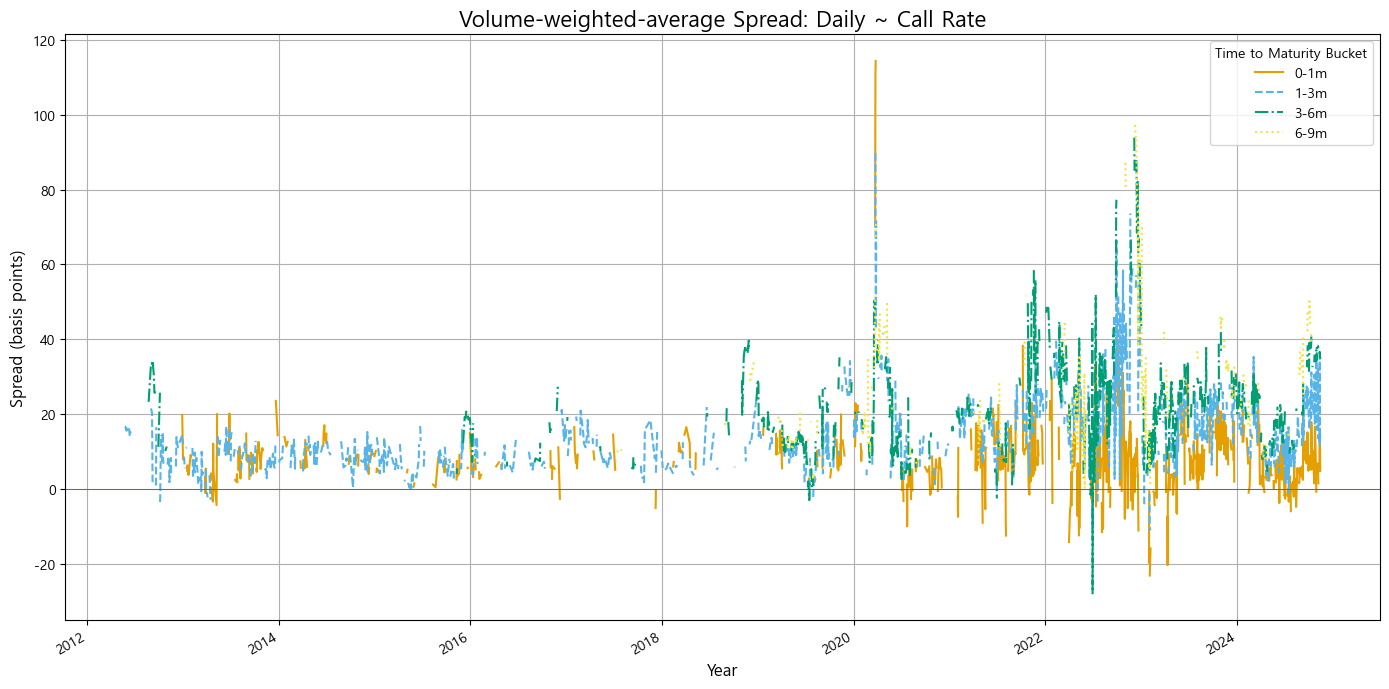

In [232]:
grouped_call = cd_call.groupby(['기준일자', 'times_to_maturity_range']).apply(
    lambda group: weighted_average(group['spread'], group['매매금액'])
).reset_index(name='credit_spread')


# Step 6: Pivot the data for plotting (separating by time_to_maturity_range)
pivoted_call = grouped_call.pivot(index='기준일자', columns='times_to_maturity_range', values='credit_spread')
plot_credit_spread(pivoted_call, "Daily ~ Call Rate")

In [233]:
cd[cd["기준일자"]==pd.to_datetime("2020-03-24")][[
    "종목명", "기준일자", "만기일", "금리", "매매금액", "times_to_maturity", "매수유형", "매도유형"
]].sort_values("times_to_maturity")

,종목명,기준일자,만기일,금리,매매금액,times_to_maturity,매수유형,매도유형
6508,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.800,49992603830,3,집합투자,증권사
6509,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.800,29995562298,3,집합투자,증권사
6511,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.850,9998479683,3,증권사,집합투자
6512,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.850,9998479683,3,증권사,집합투자
6513,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.850,9998479683,3,증권사,집합투자
6514,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.850,9998479683,3,증권사,집합투자
6515,KEB하나 금융기관영업팀 20191107-141-2,2020-03-24,2020-03-27,1.850,39993918732,3,증권사,집합투자
6510,국민 ALM부 20190430-365-1,2020-03-24,2020-04-29,1.660,9983654159,36,증권사,집합투자


In [234]:
cd[cd["기준일자"]==pd.to_datetime("2020-03-25")][[
    "종목명", "기준일자", "만기일", "금리", "매매금액", "times_to_maturity", "매수유형", "매도유형"
]].sort_values("times_to_maturity")

,종목명,기준일자,만기일,금리,매매금액,times_to_maturity,매수유형,매도유형
6516,KEB하나 금융기관영업팀 20191107-141-2,2020-03-25,2020-03-27,1.870,9998975447,2,집합투자,증권사
6517,KEB하나 금융기관영업팀 20191107-141-2,2020-03-25,2020-03-27,1.870,9998975447,2,집합투자,증권사
6519,KEB하나 금융기관영업팀 20191107-141-2,2020-03-25,2020-03-27,1.870,9998975447,2,집합투자,증권사
6520,KEB하나 금융기관영업팀 20191107-141-2,2020-03-25,2020-03-27,1.880,9998969969,2,증권사,집합투자
6521,KEB하나 금융기관영업팀 20191107-141-2,2020-03-25,2020-03-27,1.880,9998969969,2,증권사,집합투자
6523,KEB하나 금융기관영업팀 20191107-141-2,2020-03-25,2020-03-27,1.880,9998969969,2,증권사,집합투자
6518,우리 여의도기업영업지원팀 20200130-90-1,2020-03-25,2020-04-29,1.600,9984681037,35,집합투자,증권사
6522,우리 여의도기업영업지원팀 20200130-90-1,2020-03-25,2020-04-29,1.140,19978160858,35,증권사,집합투자
6524,국민 ALM부 20191105-365-1,2020-03-25,2020-11-04,1.610,9902161221,224,증권사,집합투자


In [235]:
pivoted_call[pivoted_call>50].dropna(axis=0, how='all')

times_to_maturity_range,0-1m,1-3m,3-6m,6-9m
기준일자,,,,
2020-03-19,NaN,NaN,50.072,NaN
2020-03-20,NaN,NaN,50.303,NaN
2020-03-23,70.141,NaN,NaN,51.652
2020-03-24,110.245,89.713,NaN,NaN
2020-03-25,114.379,52.380,NaN,67.341
2020-03-26,NaN,NaN,57.541,71.989
2020-03-27,NaN,71.727,NaN,NaN
2020-03-31,80.337,NaN,NaN,NaN
2021-10-20,NaN,NaN,NaN,51.502


C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2237988525.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_call = cd_call.groupby(['기준월', 'times_to_maturity_range']).apply(
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2237988525.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_call = cd_call.groupby(['기준월', 'times_to_maturity_range']).apply(


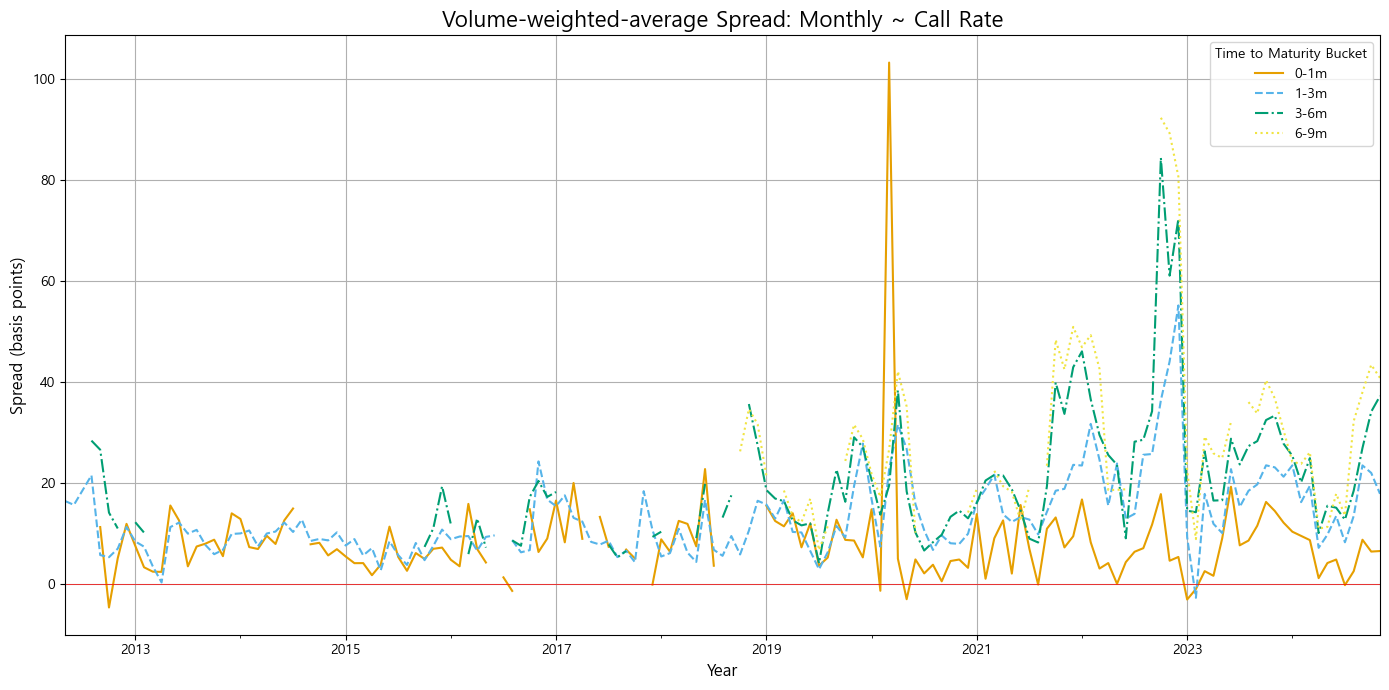

In [236]:
grouped_call = cd_call.groupby(['기준월', 'times_to_maturity_range']).apply(
    lambda group: weighted_average(group['spread'], group['매매금액'])
).reset_index(name='credit_spread')


# Step 6: Pivot the data for plotting (separating by time_to_maturity_range)
pivoted_call = grouped_call.pivot(index='기준월', columns='times_to_maturity_range', values='credit_spread')
plot_credit_spread(pivoted_call, "Monthly ~ Call Rate")

In [237]:
pivoted_call[pivoted_call<0].dropna(axis=0, how='all')

times_to_maturity_range,0-1m,1-3m,3-6m,6-9m
기준월,,,,
2012-10,-4.673,NaN,NaN,NaN
2016-08,-1.390,NaN,NaN,NaN
2017-12,-0.140,NaN,NaN,NaN
2020-02,-1.363,NaN,NaN,NaN
2020-05,-3.037,NaN,NaN,NaN
2021-08,-0.139,NaN,NaN,NaN
2023-01,-3.094,NaN,NaN,NaN
2023-02,-1.024,-2.759,NaN,NaN
2024-07,-0.249,NaN,NaN,NaN


C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\4197182603.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_repo = cd_repo.groupby(['기준일자', 'times_to_maturity_range']).apply(
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\4197182603.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_repo = cd_repo.groupby(['기준일자', 'times_to_maturity_range']).apply(


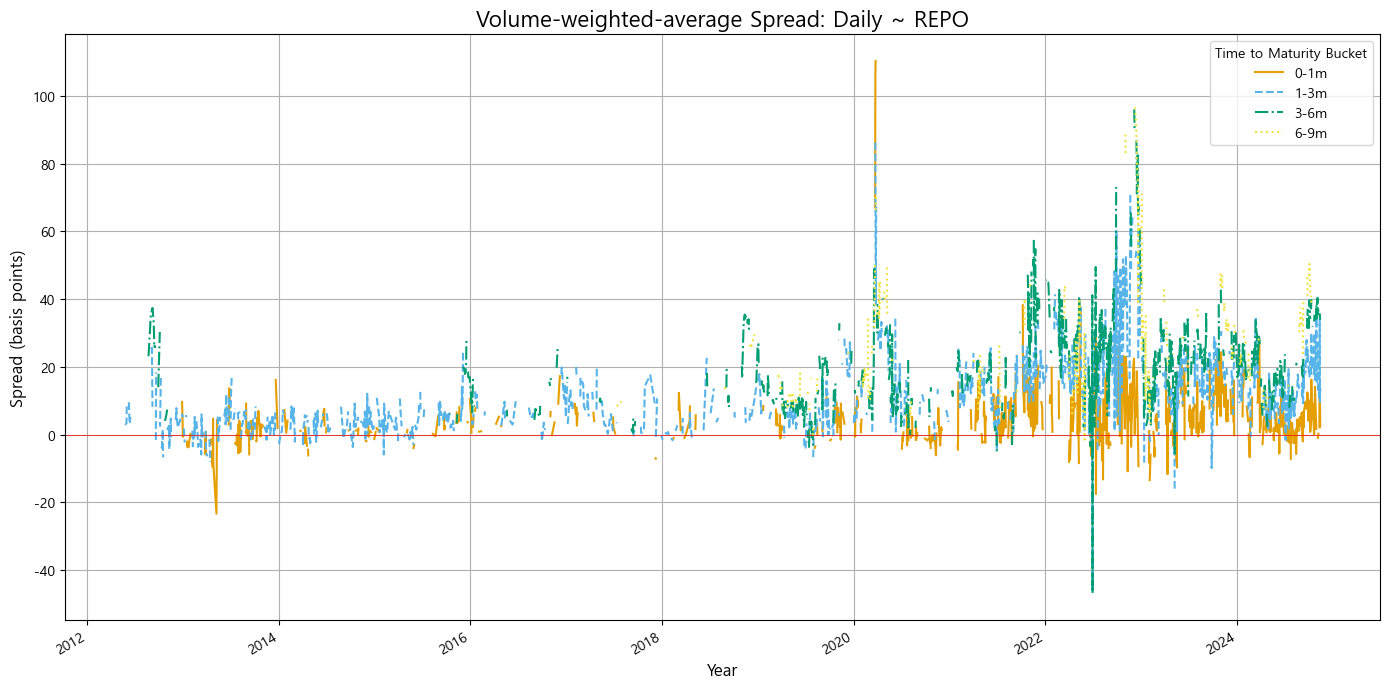

In [238]:
grouped_repo = cd_repo.groupby(['기준일자', 'times_to_maturity_range']).apply(
    lambda group: weighted_average(group['spread'], group['매매금액'])
).reset_index(name='credit_spread')


# Step 6: Pivot the data for plotting (separating by time_to_maturity_range)
pivoted_repo = grouped_repo.pivot(index='기준일자', columns='times_to_maturity_range', values='credit_spread')
plot_credit_spread(pivoted_repo, "Daily ~ REPO")

C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\620116766.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_repo = cd_repo.groupby(['기준월', 'times_to_maturity_range']).apply(
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\620116766.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_repo = cd_repo.groupby(['기준월', 'times_to_maturity_range']).apply(


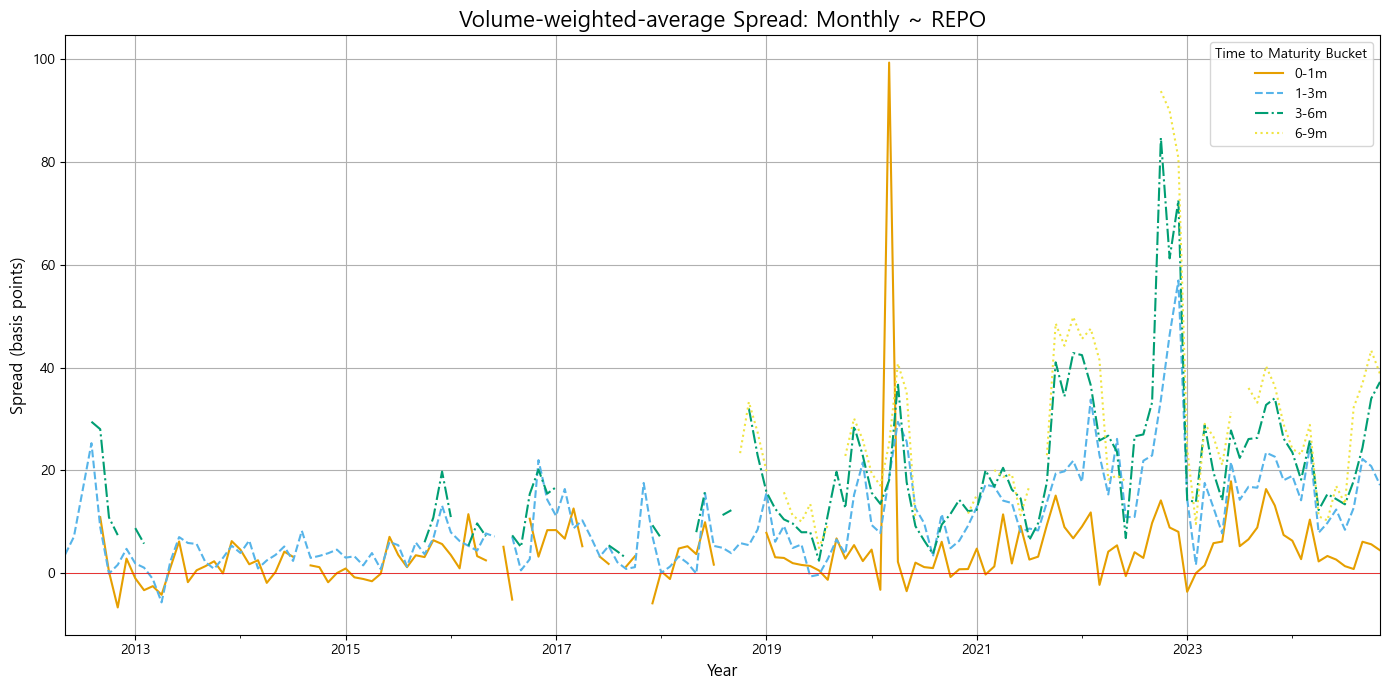

In [239]:
grouped_repo = cd_repo.groupby(['기준월', 'times_to_maturity_range']).apply(
    lambda group: weighted_average(group['spread'], group['매매금액'])
).reset_index(name='credit_spread')


# Step 6: Pivot the data for plotting (separating by time_to_maturity_range)
pivoted_repo = grouped_repo.pivot(index='기준월', columns='times_to_maturity_range', values='credit_spread')
plot_credit_spread(pivoted_repo, "Monthly ~ REPO")

In [240]:
pivoted_repo[pivoted_repo<0].dropna(axis=0, how='all').tail(10)

times_to_maturity_range,0-1m,1-3m,3-6m,6-9m
기준월,,,,
2019-07,NaN,-0.332,NaN,NaN
2019-08,-1.328,NaN,NaN,NaN
2020-02,-3.275,NaN,NaN,NaN
2020-05,-3.542,NaN,NaN,NaN
2020-10,-0.777,NaN,NaN,NaN
2021-02,-0.295,NaN,NaN,NaN
2022-03,-2.316,NaN,NaN,NaN
2022-06,-0.605,NaN,NaN,NaN
2023-01,-3.657,NaN,NaN,NaN
